In [27]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [28]:
def automate_data_processing(df, target_column, missing_value_threshold=0.5):
    threshold = len(df) * missing_value_threshold
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    
    df_cleaned = df_cleaned.dropna(subset=[target_column])
    df_cleaned['main_category'] = df['main_category']
    y = df_cleaned[target_column]
    X = df_cleaned.drop(columns=[target_column])

    df_cleaned = df_cleaned.drop_duplicates()
    
    return df_cleaned, X, y

def clean_outliers(df):
    cols_100g = [col for col in df.columns if col.endswith('_100g')]

    df[cols_100g] = df[cols_100g].applymap(lambda x: abs(x) if pd.notnull(x) else x)

    nutrient_thresholds = {
        'energy_100g': 5000,
        'fat_100g': 100,
        'saturated-fat_100g': 90,
        'carbohydrates_100g': 100,
        'sugars_100g': 100,
        'fiber_100g': 45,
        'proteins_100g': 90,
        'salt_100g': 10,
        'sodium_100g': 6
    }

    for col in cols_100g:
        threshold = nutrient_thresholds.get(col, 100)
        df[col] = df[col].apply(lambda x: x if x <= threshold else float('NaN'))

    return df

In [29]:
pd.set_option('display.max_rows', 500)
df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')
df.head()

/tmp/ipykernel_30/2123920834.py:2: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df.shape

(320772, 162)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


On voit grâce a df.info() que nous avons **106 données quantitatives** et **56 données catégorielles**

**AFFICHAGE DES PROPORTIONS DE VALEURS MANQUANTES**

In [32]:
df.isna().mean()

code                                          0.000072
url                                           0.000072
creator                                       0.000006
created_t                                     0.000009
created_datetime                              0.000028
last_modified_t                               0.000000
last_modified_datetime                        0.000000
product_name                                  0.055373
generic_name                                  0.835413
quantity                                      0.673229
packaging                                     0.753844
packaging_tags                                0.753841
brands                                        0.088574
brands_tags                                   0.088599
categories                                    0.736854
categories_tags                               0.736919
categories_fr                                 0.736850
origins                                       0.930823
origins_ta

**Appel de la fonction de préparation des données**

Notre target sera le Nutriscore qui peut facilement être prédit en fonction des qualités nutritives du produit tels que le sucre, le sel, les acides gras saturés, les protéines, etc...

In [33]:
target = 'nutrition_grade_fr'
df_cleaned, X, y = automate_data_processing(df, target)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221210 entries, 1 to 320768
Data columns (total 35 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     221210 non-null  object 
 1   url                                      221210 non-null  object 
 2   creator                                  221210 non-null  object 
 3   created_t                                221210 non-null  object 
 4   created_datetime                         221209 non-null  object 
 5   last_modified_t                          221210 non-null  object 
 6   last_modified_datetime                   221210 non-null  object 
 7   product_name                             218463 non-null  object 
 8   brands                                   216572 non-null  object 
 9   brands_tags                              216571 non-null  object 
 10  countries                            

Il nous reste après le nettoyage des valeurs manquantes **14 données quantitatives** et **21 données catégorielles**. On supprime les features inutiles

In [34]:
df_cleaned = df_cleaned.drop(columns=['code','url','creator','created_t','created_datetime', 'last_modified_t', 'last_modified_datetime','brands','countries','countries_fr','additives_n','ingredients_from_palm_oil_n', 'states_tags', 'states_fr', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'serving_size'])

On vérifie les dimensions de notre ensemble

In [35]:
df_cleaned.shape

(221210, 18)

In [36]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221210 entries, 1 to 320768
Data columns (total 18 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   product_name                             218463 non-null  object 
 1   brands_tags                              216571 non-null  object 
 2   countries_tags                           221153 non-null  object 
 3   ingredients_text                         196179 non-null  object 
 4   additives                                196158 non-null  object 
 5   ingredients_that_may_be_from_palm_oil_n  196179 non-null  float64
 6   nutrition_grade_fr                       221210 non-null  object 
 7   states                                   221210 non-null  object 
 8   energy_100g                              221019 non-null  float64
 9   fat_100g                                 203733 non-null  float64
 10  saturated-fat_100g                   

In [37]:
df_cleaned[target].isna().mean()

0.0

On supprime les doublons

In [38]:
df_cleaned = df_cleaned.drop_duplicates()

In [39]:
features = df_cleaned.columns
X = df_cleaned[features]
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218756 entries, 1 to 320768
Data columns (total 18 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   product_name                             216036 non-null  object 
 1   brands_tags                              214148 non-null  object 
 2   countries_tags                           218699 non-null  object 
 3   ingredients_text                         193770 non-null  object 
 4   additives                                193749 non-null  object 
 5   ingredients_that_may_be_from_palm_oil_n  193770 non-null  float64
 6   nutrition_grade_fr                       218756 non-null  object 
 7   states                                   218756 non-null  object 
 8   energy_100g                              218565 non-null  float64
 9   fat_100g                                 201295 non-null  float64
 10  saturated-fat_100g                   

**Premiere Visualisation**

In [40]:
X.describe()

,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,193770.000000,2.185650e+05,201295.000000,218565.000000,201269.000000,218565.000000,191468.000000,218565.000000,218565.000000,218565.000000
mean,0.057795,1.196891e+03,13.365645,4.978549,33.249836,15.026055,2.827495,7.770389,1.648326,0.648947
std,0.276366,7.028155e+03,16.162775,7.665591,28.291293,21.178559,13.083862,8.113202,138.184874,54.403493
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000
25%,0.000000,4.530000e+02,0.880000,0.000000,7.020000,1.300000,0.000000,1.900000,0.100000,0.039370
50%,0.000000,1.194000e+03,7.140000,1.790000,24.140000,5.000000,1.500000,5.700000,0.650000,0.255906
75%,0.000000,1.717000e+03,21.430000,7.140000,59.000000,23.080000,3.600000,10.710000,1.361440,0.536000
max,6.000000,3.251373e+06,714.290000,550.000000,209.380000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000


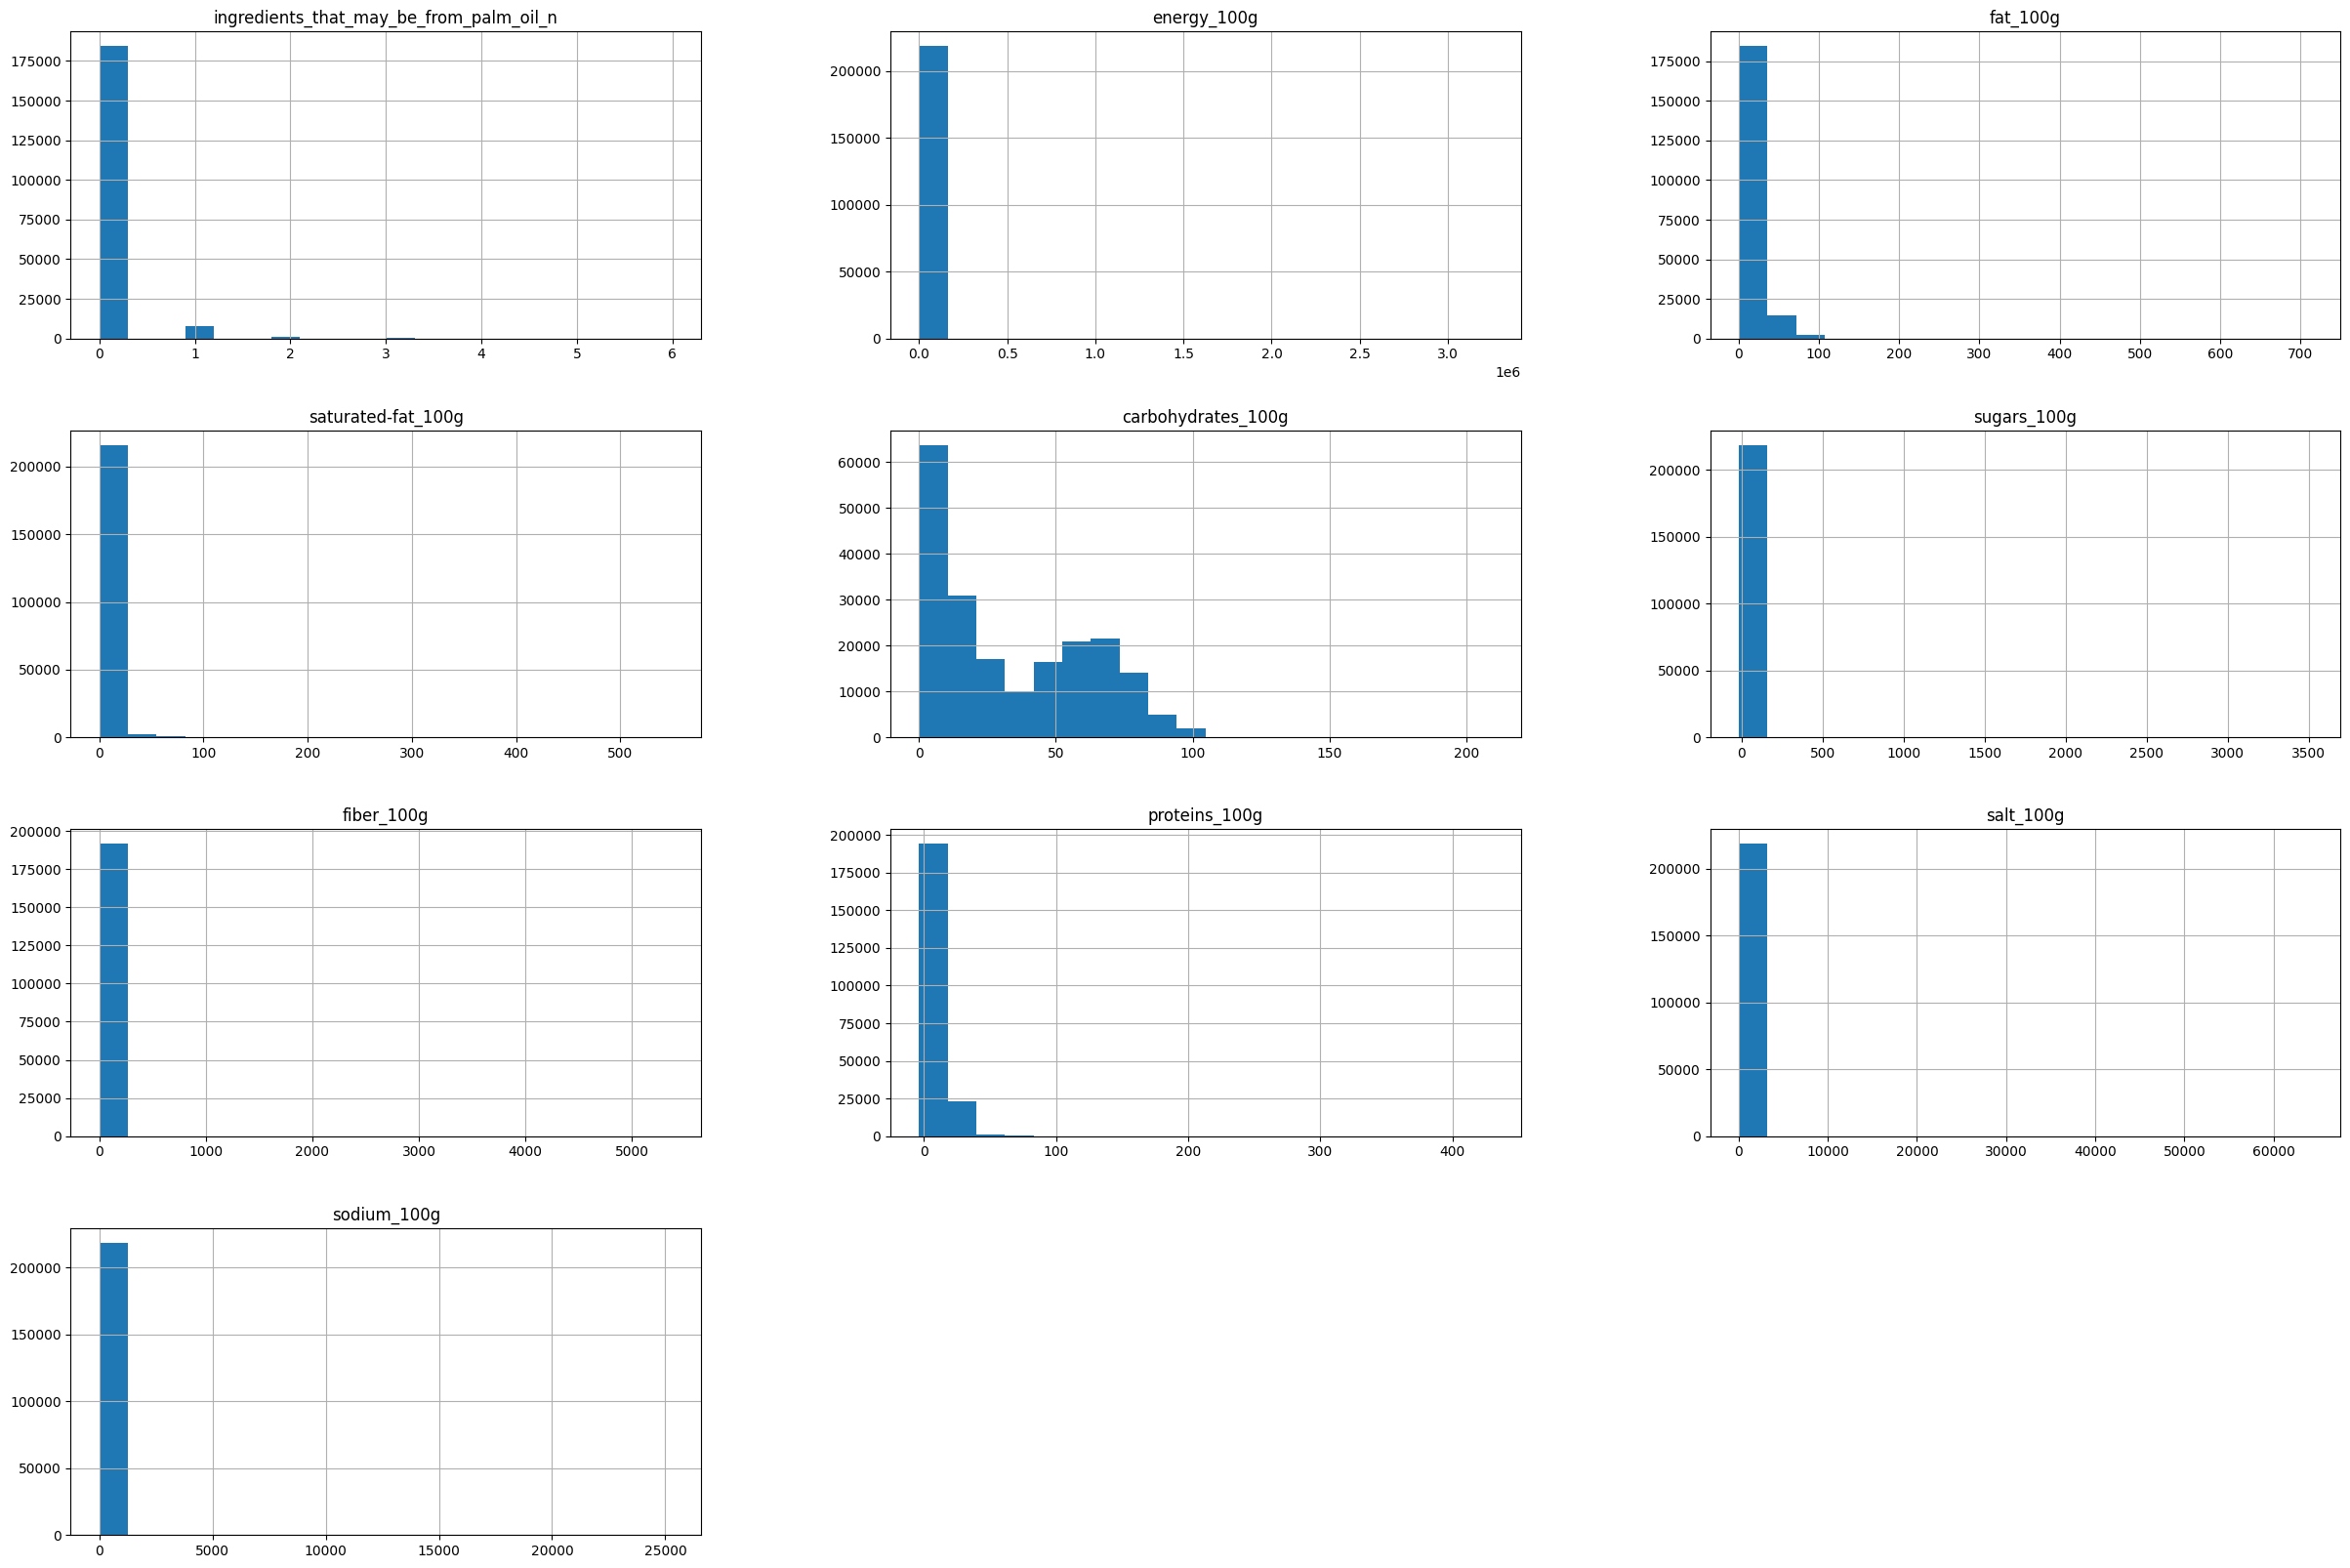

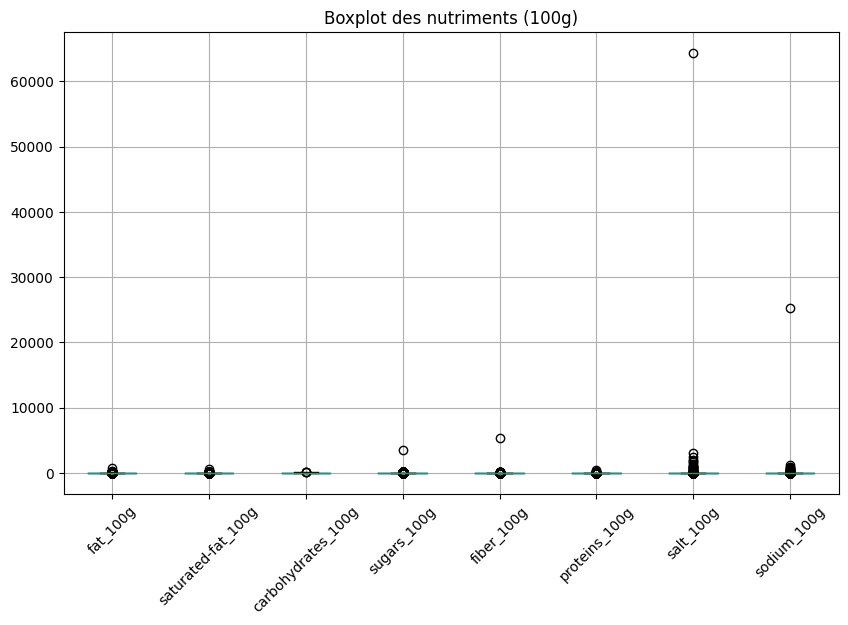

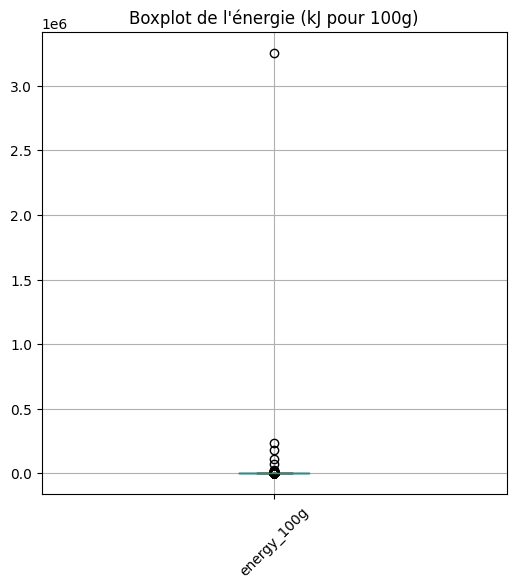

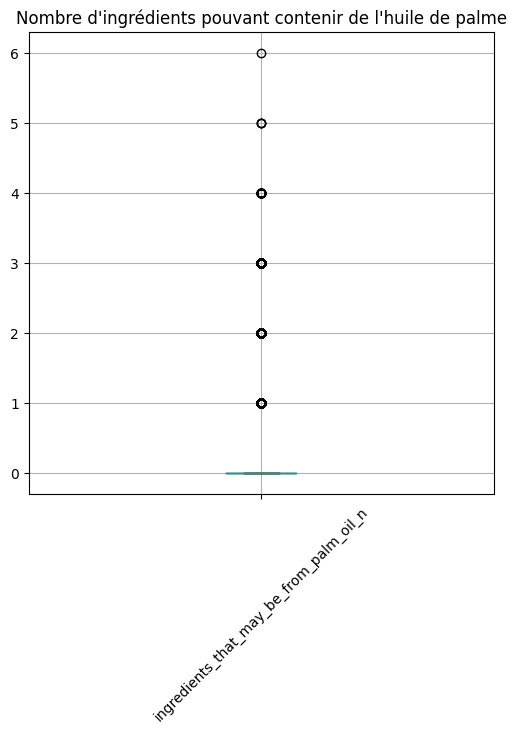

In [41]:
X.hist(bins=20, figsize=(30, 20))
plt.show()

nutriment_features = [col for col in X.columns if col.endswith('_100g') and col != 'energy_100g']

plt.figure(figsize=(10, 6))
X[nutriment_features].boxplot() 
plt.title("Boxplot des nutriments (100g)")
plt.xticks(rotation=45)
plt.show()

# Figure pour l'énergie
plt.figure(figsize=(6, 6))
X[['energy_100g']].boxplot()
plt.title("Boxplot de l'énergie (kJ pour 100g)")
plt.xticks(rotation=45)
plt.show()

# Figure pour l'énergie
plt.figure(figsize=(6, 6))
X[['ingredients_that_may_be_from_palm_oil_n']].boxplot()
plt.title("Nombre d'ingrédients pouvant contenir de l'huile de palme")
plt.xticks(rotation=45)
plt.show()

On restreint notre projet aux produits vendus en France et dans ses DOM-TOMs

In [42]:
keywords = [
    'france', 'guadeloupe', 'martinique', 'guyane', 'reunion', 'mayotte', 
    'saint-pierre-et-miquelon', 'saint-barthélemy', 'saint-martin',
    'polynésie française', 'nouvelle-calédonie', 'wallis-et-futuna', 'french-guiana'
]

X = X[X['countries_tags'].str.contains('|'.join(keywords), case=False, na=False)]

X.head()

,product_name,brands_tags,countries_tags,ingredients_text,additives,ingredients_that_may_be_from_palm_oil_n,nutrition_grade_fr,states,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,main_category
106,Lion Peanut x2,sunridge,"en:france,en:united-states","Milk chocolate coating (evaporated cane juice,...",[ milk-chocolate-coating -> en:milk-chocolate...,0.0,e,"en:to-be-completed, en:nutrition-facts-complet...",1883.0,20.0,12.5,70.0,57.5,2.5,2.5,0.09652,0.038000,NaN
190,Mini Confettis,alice-delice,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",1753.0,NaN,0.8,NaN,87.7,0.9,0.6,0.01000,0.003937,NaN
191,Praliné Amande Et Noisette,alice-delice,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",2406.0,NaN,2.9,NaN,50.3,3.9,9.5,0.00300,0.001181,NaN
226,"Pepsi, Nouveau goût !",pepsi,en:france,"Eau gazéifiée, sucre, colorant caramel E150d, ...",[ eau-gazeifiee -> fr:eau-gazeifiee ] [ eau...,0.0,e,"en:to-be-checked, en:complete, en:nutrition-fa...",177.0,0.0,0.0,10.4,10.4,0.0,0.0,0.02540,0.010000,en:sodas
234,Tarte Poireaux Et Lardons,bo-frost,en:france,NaN,NaN,NaN,d,"en:to-be-completed, en:nutrition-facts-complet...",1079.0,NaN,11.0,NaN,1.0,1.4,7.5,0.80000,0.314961,NaN


In [43]:
X.shape

(61386, 18)

On supprime dans un premier temps les lignes ayant des valeurs aberrerantes d'un pdv métier

In [44]:
X = clean_outliers(X)

/tmp/ipykernel_30/563544744.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols_100g] = df[cols_100g].applymap(lambda x: abs(x) if pd.notnull(x) else x)


main_category
en:cakes            12
en:sugary-snacks    11
en:breakfasts        4
en:sandwiches        1
en:breads            1
en:pastries          1
Name: count, dtype: int64


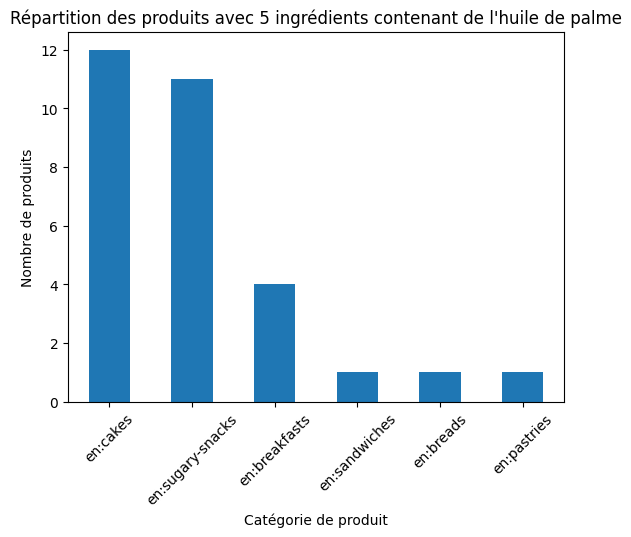

In [45]:
palm_oil_5_ingredients = X[X['ingredients_that_may_be_from_palm_oil_n'] >= 4]

print(palm_oil_5_ingredients['main_category'].value_counts())
palm_oil_5_ingredients['main_category'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=45)
plt.title("Répartition des produits avec 5 ingrédients contenant de l'huile de palme")
plt.show()

main_category
en:vegetable-oils       149
en:olive-oils            64
en:virgin-olive-oils     15
en:animal-fats            7
en:vegetable-fats         3
en:jams                   2
en:canned-sardines        2
en:dried-fruits           1
fr:lardons                1
en:pickles                1
en:sugary-snacks          1
en:nuts                   1
en:salted-spreads         1
en:pastas                 1
en:candies                1
en:fats                   1
en:biscuits               1
en:condiments             1
en:cheeses                1
en:butters                1
Name: count, dtype: int64


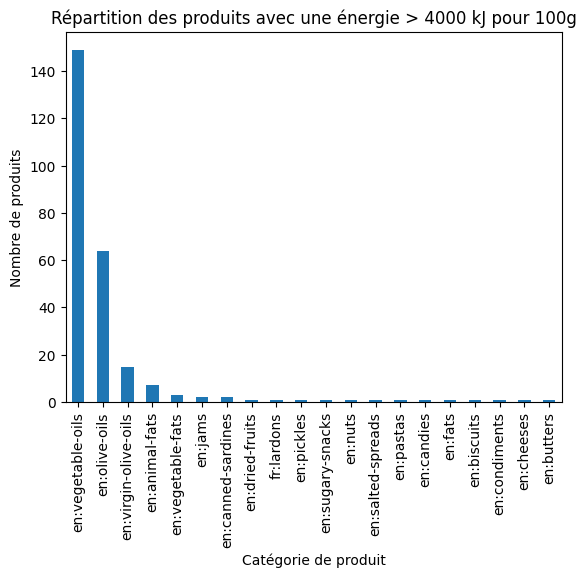

In [46]:
energy_threshold = 3500

high_energy_products = X[X['energy_100g'] > energy_threshold]

print(high_energy_products['main_category'].value_counts())

high_energy_products['main_category'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec une énergie > 4000 kJ pour 100g")
plt.show()

In [47]:
X.describe()

,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,40944.000000,61257.000000,44190.000000,61271.000000,44133.000000,61302.000000,44716.000000,61295.000000,60810.000000,60970.000000
mean,0.164737,1120.476391,13.323010,5.385415,27.811494,13.394959,2.437539,7.721594,0.835795,0.341343
std,0.471337,776.647622,16.665496,8.260676,27.246832,19.012256,3.705951,7.753926,1.081791,0.489094
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,434.000000,1.400000,0.300000,4.100000,1.000000,0.000000,1.900000,0.080000,0.031496
50%,0.000000,1040.000000,7.000000,2.000000,14.900000,4.000000,1.300000,6.000000,0.540000,0.216535
75%,0.000000,1658.000000,21.000000,7.400000,53.000000,17.900000,3.200000,10.800000,1.200000,0.472441
max,5.000000,4987.000000,100.000000,90.000000,100.000000,100.000000,45.000000,90.000000,10.000000,6.000000


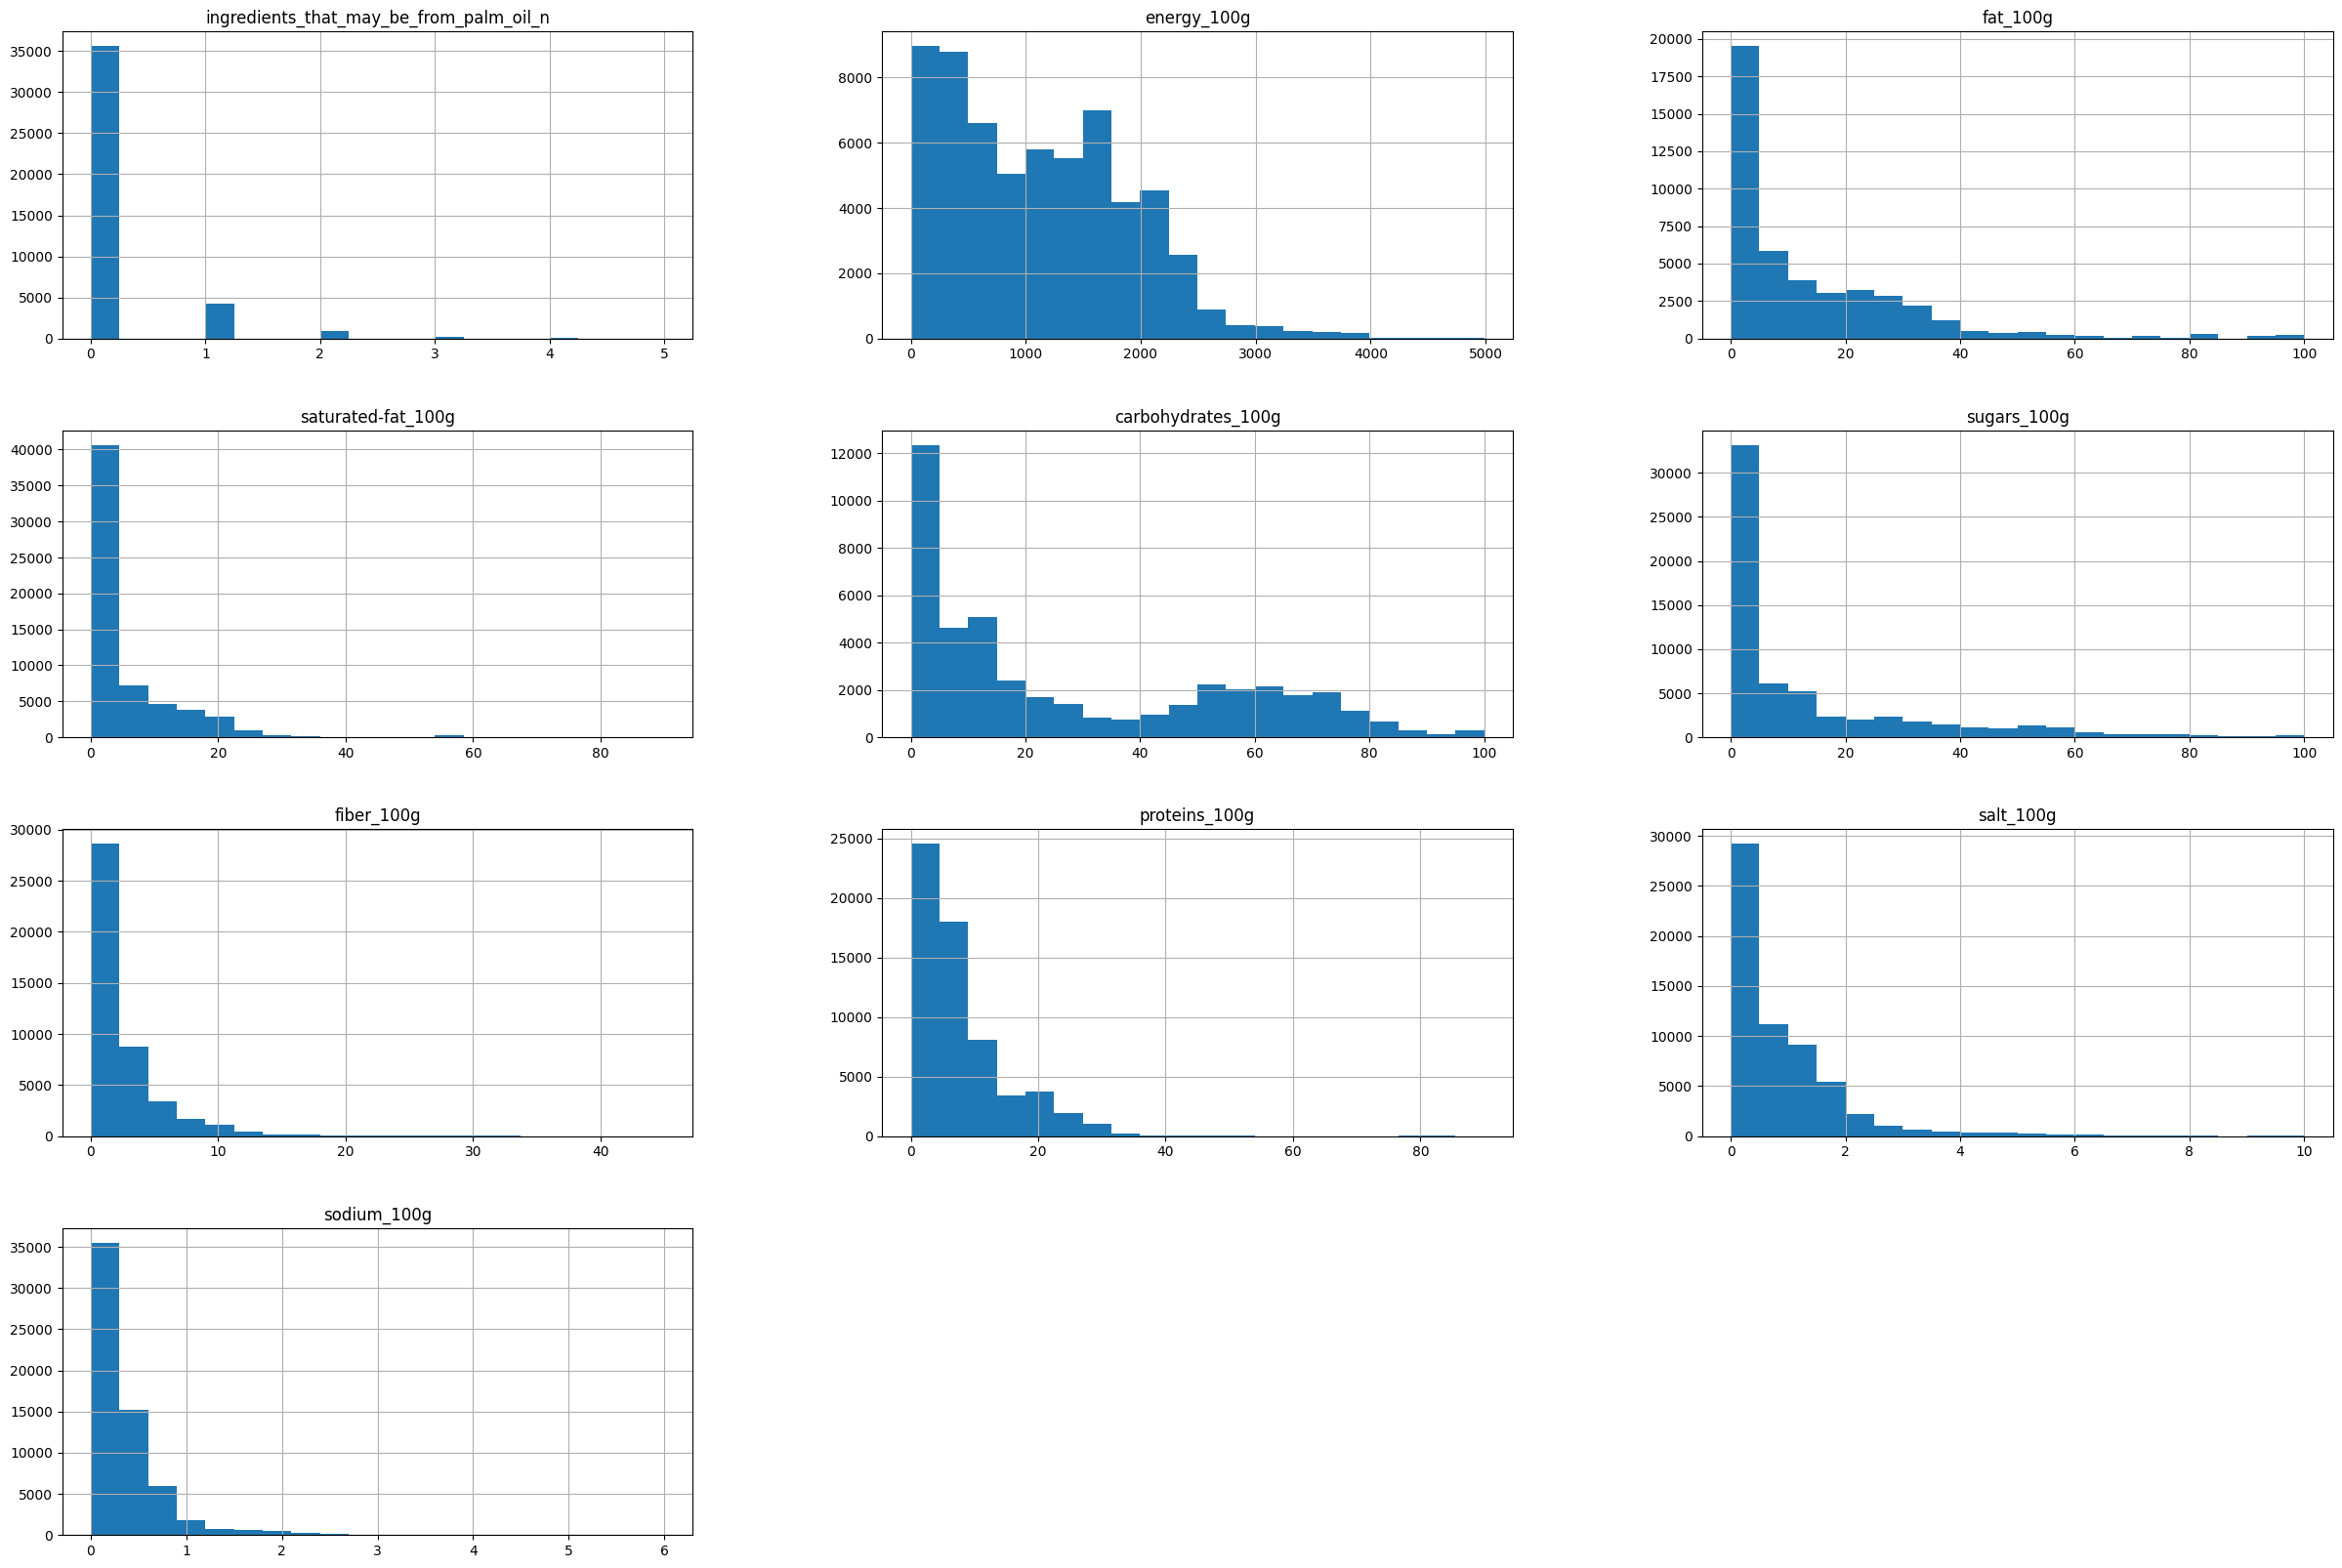

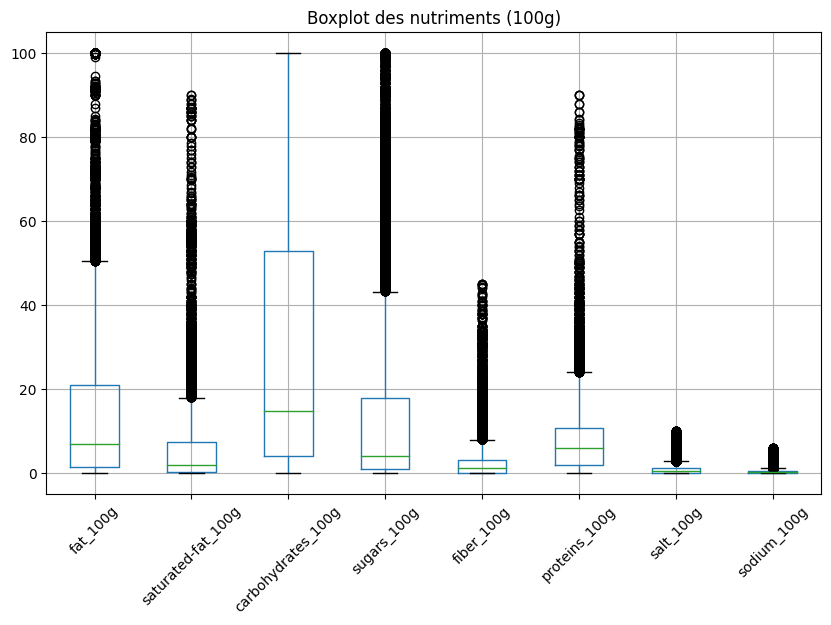

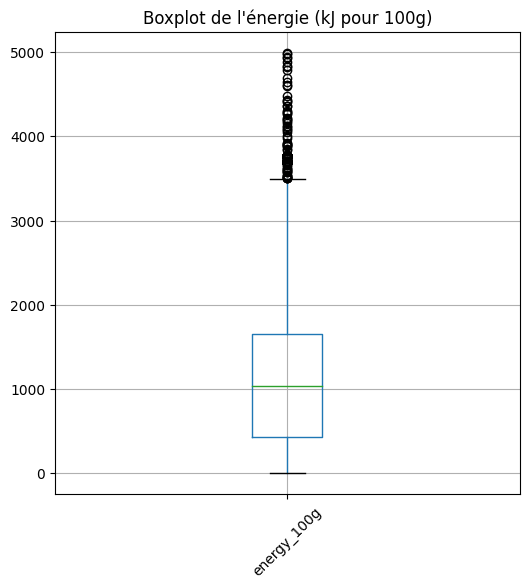

In [48]:
X.hist(bins=20, figsize=(30, 20))
plt.show()

plt.figure(figsize=(10, 6))
X[nutriment_features].boxplot() 
plt.title("Boxplot des nutriments (100g)")
plt.xticks(rotation=45)
plt.show()

# Figure pour l'énergie
plt.figure(figsize=(6, 6))
X[['energy_100g']].boxplot()
plt.title("Boxplot de l'énergie (kJ pour 100g)")
plt.xticks(rotation=45)
plt.show()

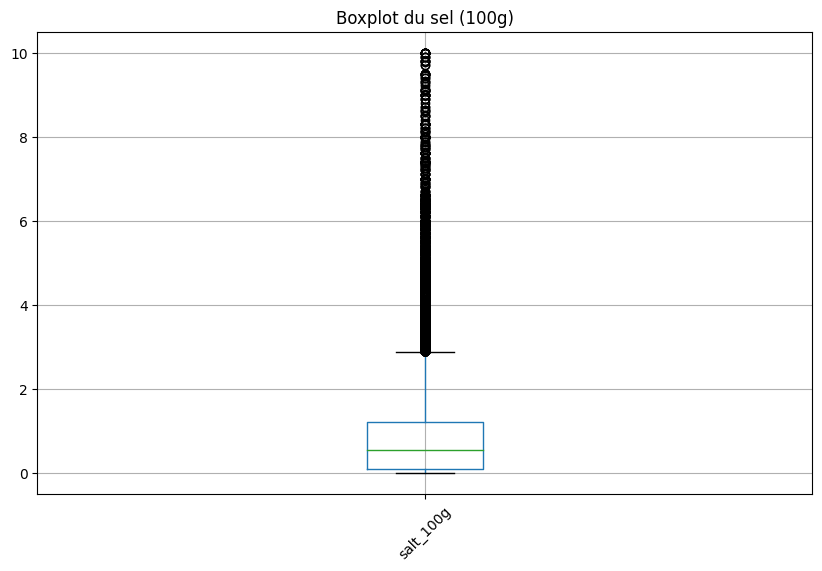

(array([1]), [Text(1, 0, 'sodium_100g')])

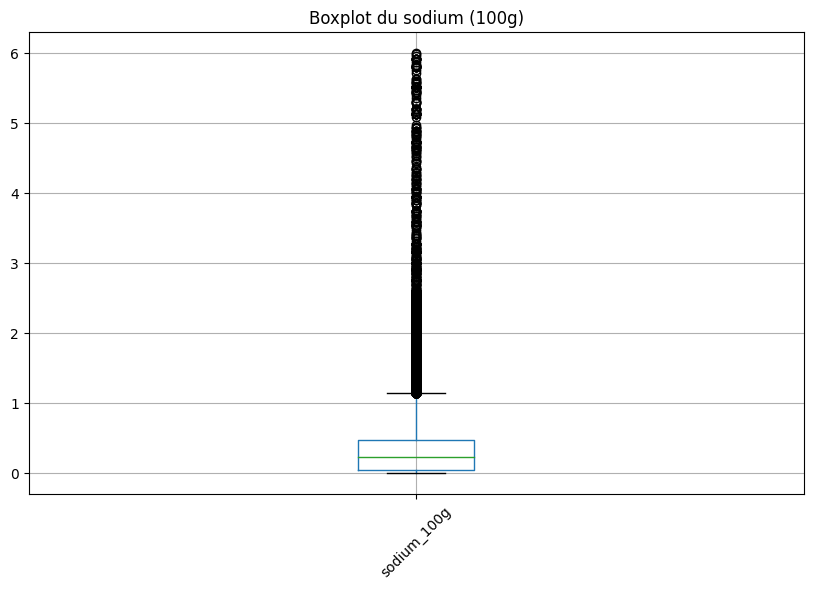

In [49]:
plt.figure(figsize=(10, 6))
X[['salt_100g']].boxplot() 
plt.title("Boxplot du sel (100g)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
X[['sodium_100g']].boxplot() 
plt.title("Boxplot du sodium (100g)")
plt.xticks(rotation=45)

In [50]:
categorical_columns = X.select_dtypes(include='object').columns

for column in categorical_columns:
    exploded_values = X[column].str.split(',').explode()
    value_counts = exploded_values.value_counts(normalize=True)*100
    print(f"Fréquences pour '{column}':")
    print(value_counts)

Fréquences pour 'product_name':
product_name
                                         0.331071
 Surgelé                                 0.161756
Orange                                   0.072563
Mayonnaise                               0.065005
Huile d'olive vierge extra               0.061981
                                           ...   
Mayonnaise à la Moutarde à l'Ancienne    0.001512
Mayonnaise à la moutardes de dijon       0.001512
Brioche Fourrée Pocket Gout Chocolat     0.001512
Fromage blanc fondu (30 % MG)            0.001512
Thé vert Earl grey                       0.001512
Name: proportion, Length: 53769, dtype: float64
Fréquences pour 'brands_tags':
brands_tags
carrefour                    3.968517
auchan                       3.247849
u                            2.646139
marque-repere                2.589427
leader-price                 2.210419
                               ...   
belca                        0.001383
a-snc-hameau-de-st-didier    0.001383
le-mazet  

In [51]:
X.isna().mean() * 100

product_name                                0.555501
brands_tags                                 0.566905
countries_tags                              0.000000
ingredients_text                           33.300753
additives                                  33.315414
ingredients_that_may_be_from_palm_oil_n    33.300753
nutrition_grade_fr                          0.000000
states                                      0.000000
energy_100g                                 0.210146
fat_100g                                   28.012902
saturated-fat_100g                          0.187339
carbohydrates_100g                         28.105757
sugars_100g                                 0.136839
fiber_100g                                 27.156029
proteins_100g                               0.148242
salt_100g                                   0.938325
sodium_100g                                 0.677679
main_category                              27.550256
dtype: float64

<Axes: >

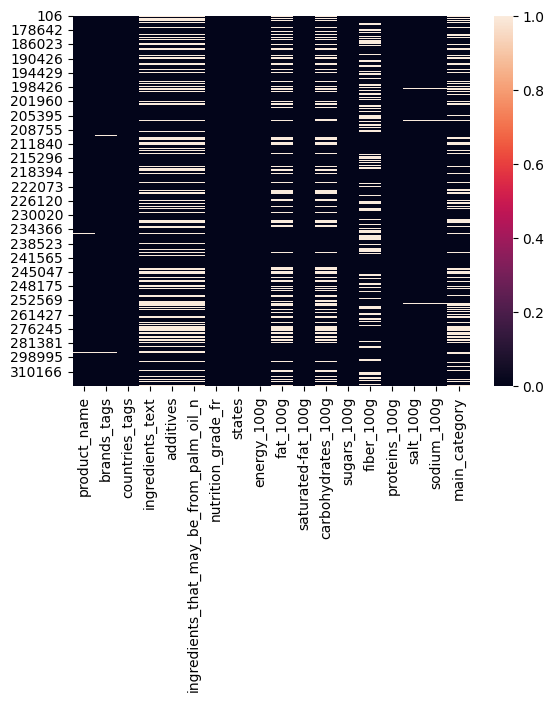

In [55]:
#sns.heatmap(X[['ingredients_text','additives', 'ingredients_that_may_be_from_palm_oil_n', 'fat_100g', 'carbohydrates_100g', 'fiber_100g', 'main_category']].isnull(), cbar=False)
sns.heatmap(X.isnull(), cbar=True)